In [5]:
# If you are a developer, you may want to reload the packages on the fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

# import standard python libraries
# import matplotlib as mpl
# %matplotlib inline
# mpl.rcParams['figure.dpi'] = 96
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess
from scipy.stats import bootstrap
from textwrap import wrap
from matplotlib import font_manager
font_dirs = ["~/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
susielu = ["#b84873", "#6dbc5f","#5a3789","#bdab3d","#6d80d8","#bd7635","#bf68b8","#46c19a","#ba4b41","#71883b"]
sns.set_theme(context="paper", style='whitegrid', palette=susielu, font="Arial")

os.chdir('/home/izhegalova/ecoli_microc')

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe as bf
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: Unable to import required dependencies:
pytz: No module named 'pytz'

In [3]:
# %% create bins
resolution = 10
clr = cooler.Cooler('data/wt.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))
df_chromsizes = clr.chromsizes
bins = cooler.binnify(df_chromsizes, resolution)
bins.chrom = bins.chrom.astype(str)
fasta_records = bf.load_fasta('data/genome.fasta')
view_df_chromsizes = clr.chromsizes.reset_index()
view_df_chromsizes.columns = ['chrom', 'end']
view_df_chromsizes['start'] = 0
view_df_chromsizes['name'] = 'NC_000913.3'
view_df_chromsizes = view_df_chromsizes[['chrom', 'start', 'end', 'name']]

In [4]:
expected = cooltools.expected_cis(clr, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


In [ ]:
%%bash
# download data
source ~/.bashrc
source activate ecoli_microc;
cd ecoli_microc/data/
# gdown https://drive.google.com/uc?id=13EVqjJxw71ali7Hib4-zZ1DTj74bIXeH

In [6]:
TU_df = pd.read_csv('data/Operon_TU_counts.tsv', sep='\t', index_col=0)
TU_df.columns = ['chrom', 'start', 'end', 'TU_name', 'strand', 'GeneID', 'genes', 'ngenes', 
                 'protein_codin', 
                 'sigma', 'nascent_wt',
                 'totat_wt', 'nascent_wt44', 'totat_wt44']
TU_df['chrom'] = 'NC_000913.3'
TU_df['length'] = TU_df.end - TU_df.start
bin_labels_4 = ['short', '25-50%', '50-75%', 'long']
TU_df['length_group'] = pd.qcut(TU_df['length'], 4, labels=False)
TU_df['lengthBool_group'] = np.where(TU_df['length'] > TU_df.length.median(), 'long', 'short')

bin_labels_4 = ['bottom 50%', '50-75%', '75-90%', '>90%']
TU_df['nascentCust_group'] = pd.qcut(TU_df['nascent_wt'], 
                                          q=[0, .5, .75, .9, 1],
                                          labels=bin_labels_4)
TU_df['HeatResponsegroup'] = 'no'
TU_df.head()

NameError: name 'pd' is not defined

# Rifampicin

In [5]:
# %% create bins
resolution = 10
clr_rif25 = cooler.Cooler('data/rif25.MG1655.mapq_30.10.mcool::resolutions/' + str(resolution))
clr_rif750 = cooler.Cooler('data/rif750.MG1655.mapq_30.10.mcool::resolutions/' + str(resolution))

In [6]:
expected_rif25 = cooltools.expected_cis(clr_rif25, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True
expected_rif750 = cooltools.expected_cis(clr_rif750, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


# TU

In [265]:
flank = 2000
pup_TU_ooe = coolpup.pileup(clr, TU_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32)
# sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup_TU_ooe,
#              rows='lengthBool_group1', row_order=['long'], #, 'short'
#              cols='nascentCust_group2', 
#              col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
#              score=False, cmap='coolwarm', scale='log', sym=True,
#              vmax=2.5, #vmin=0.35, 
#              height=5)

# plt.savefig('results/av_TU.ooe.res1.nascentCust.lengthBool.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()
# plt.clf()

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [269]:
flank = 2000
pup_TU_notOoe = coolpup.pileup(clr, TU_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     # expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32)
# sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup_TU_notOoe,
#              rows='lengthBool_group1', row_order=['long'],
#              cols='nascentCust_group2', 
#              col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
#              score=False, cmap='fall', scale='log', sym=False,
#              # vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
#              vmin=0.000015, vmax=0.0002,
#              height=5)

# plt.savefig('results/av_TU.res1.nascentCust.lengthBool.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2186: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


AttributeError: 'DataFrame' object has no attribute 'feature1'

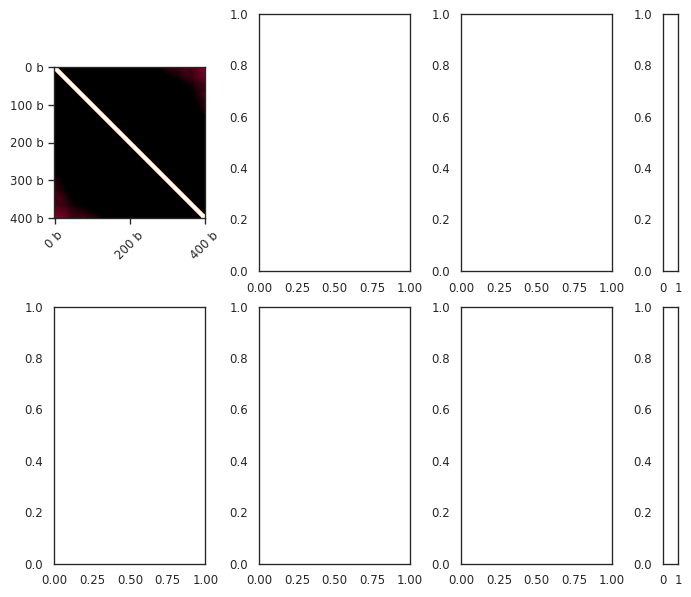

In [272]:
import matplotlib.cm
from matplotlib import ticker
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    ABCJ
    DEFI
    """, figsize=(18*cm, 5*3.1*cm), 
    constrained_layout = True,
    gridspec_kw={'width_ratios':[1, 1, 1, 0.1]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'TSS', 'TES', '+2 kb']


letter_dic = {'A':0,'B':0,'C':0,'D':1,'E':1,'F':1}
for letter in letter_dic.keys():
    i = letter_dic[letter]
    if letter in ['A','B','C']:
        current_pup = pup_TU_notOoe
    if letter in ['D','E','F']:
        current_pup = pup_TU_ooe

    # norm = mpl.colors.LogNorm(vmin=0.000002, vmax=0.001)
    if i == 1:
        norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.001) 
    elif i == 0:
        norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.0005) 
    # else: 
    #     norm = mpl.colors.LogNorm(vmin=0.000002, vmax=0.001)
    
    im = axs[letter].imshow(
        current_pup.loc[i, 'data'],
        norm=norm,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "A":
        axs[letter].set(xticks=[], yticks=ticks_pixels_borders, 
                        yticklabels=ticks_borders,
                        title="%s,\nn=%s" %(current_pup.feature1[i], current_pup.n[i]),
                         # ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter == 'B':
        axs[letter].set(xticks=[], yticks=[], 
                        title="%s,\nn=%s" %(current_pup.feature1[i], current_pup.n[i]))
    
    if letter == 'C':
        axs[letter].set(xticks=[], yticks=[], 
                        title="%s,\nn=%s" %("HpCD", current_pup.n[i]),
                       )
    if letter == "D":
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, 
                        yticks=ticks_pixels_borders, yticklabels=ticks_borders, 
                        #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                        #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter in ['E','F']:
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders,
                         yticks=[], #xlabel="\n".join(wrap('relative position, kbp', 25))
                       )
cax = axs['J']
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'fall'), ticks=[0.000002, 0.00001, 0.0001, 0.001],
             format=ticker.FuncFormatter(fmt),
             cax=cax, label = 'log10 mean ICed Hi-C')
# cax.set_yticklabels([2e-06, 1e-05, 1e-04, 5e-04])
cax.set_yticklabels([], minor=True)
# cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

# plt.savefig('results/av_feature_hic.mean.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

# Operons

In [ ]:
# %% operons
operons_df = pd.read_excel('data/operon_counts.xlsx', index_col=0)

operons_df['chrom'] = 'NC_000913.3'
bin_labels_4 = ['short', '25-50%', '50-75%', 'long']
operons_df['length_group'] = pd.qcut(operons_df['length'], 4, labels=False)
operons_df['lengthBool_group'] = np.where(operons_df['length'] > operons_df.length.median(), 'long', 'short')

bin_labels_4 = ['bottom 50%', '50-75%', '75-90%', '>90%']
operons_df['nascentCust_group'] = pd.qcut(operons_df['nascent_count'], 
                                          q=[0, .5, .75, .9, 1],
                                          labels=bin_labels_4)
bin_labels_nascent = ['0-33.3%', '33.3%-66.6%', '66.6-100%']
operons_df['nascent_group'] = pd.qcut(operons_df['nascent_count'], 3, labels=bin_labels_nascent)
operons_df.head()

# operons_df.loc[:,['chrom', 'start', 'end', 'operon_name', 'ngenes', 'strand']].to_csv(
#     'data/operons.bed', sep='\t', index=False, header=False) 
# operons_df.tail()
# operons_df.query('nascentCust_group == ">90%"').loc[:,['chrom', 'start', 'end', 'operon_name', 'ngenes', 'strand']].to_csv(
#     'data/operons.nascTop10.bed', sep='\t', index=False, header=False) 
# operons_df.query('nascent_count == 0').loc[:,['chrom', 'start', 'end', 'operon_name', 'ngenes', 'strand']].to_csv(
#     'data/operons.nascBot25.bed', sep='\t', index=False, header=False) 
# operons_df.query('nascent_count > 0 and nascentCust_group ~= ">90%"').loc[:,['chrom', 'start', 'end', 'operon_name', 'ngenes', 'strand']].to_csv(
#     'data/operons.average.bed', sep='\t', index=False, header=False) 

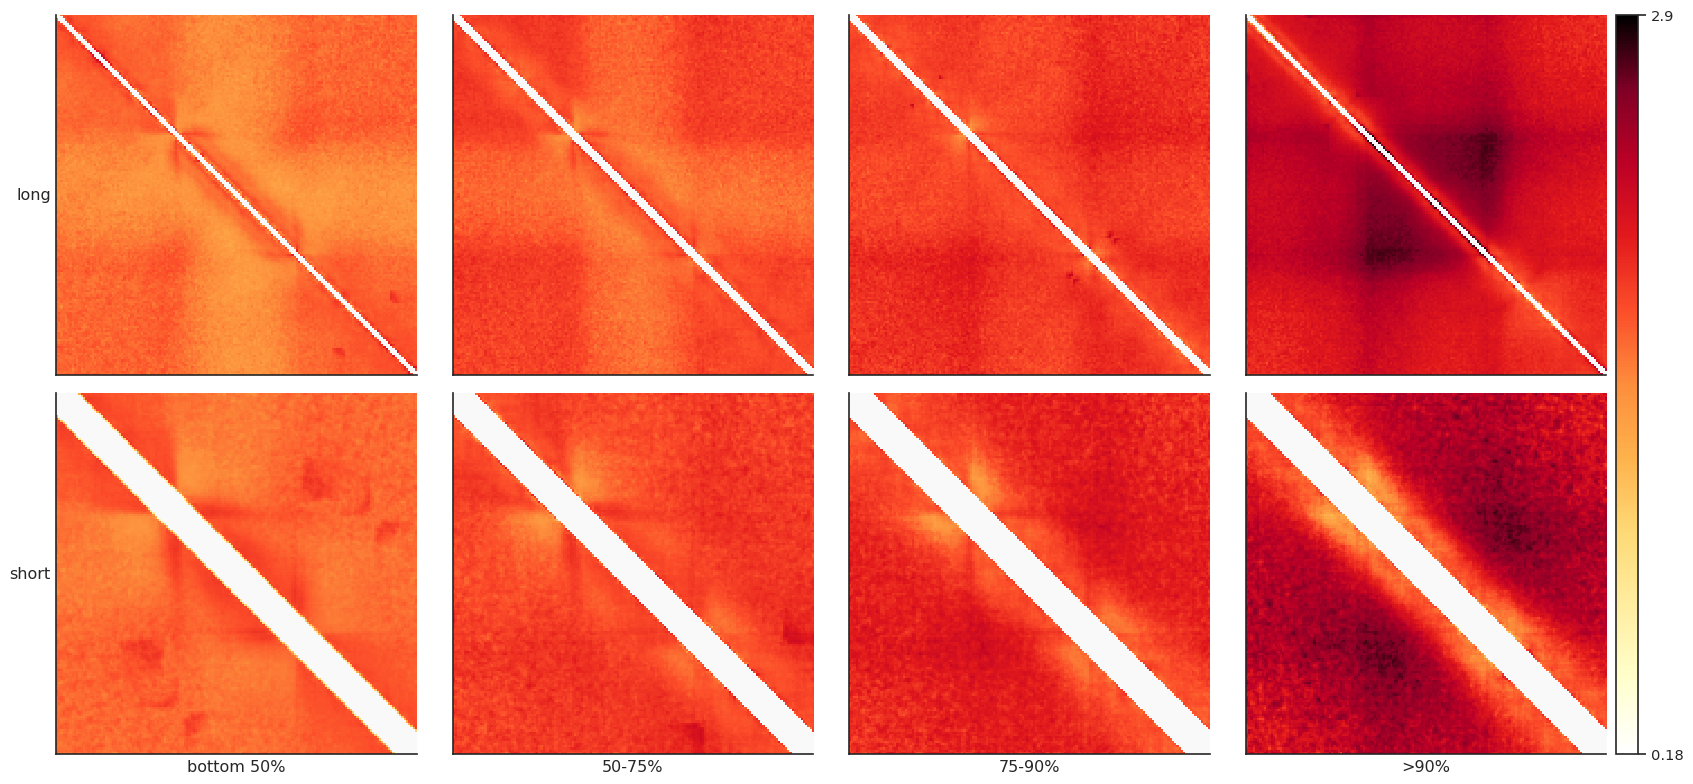

In [ ]:
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='fall', scale='log', sym=False,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             #vmin=0.000015, vmax=0.001,
             height=5)

plt.savefig('results/av_operon.flank2k.nascentCust.lengthBool.25bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

INFO:coolpuppy:Can't set both vmin and vmax and get symmetrical scale. Plotting non-symmetrical


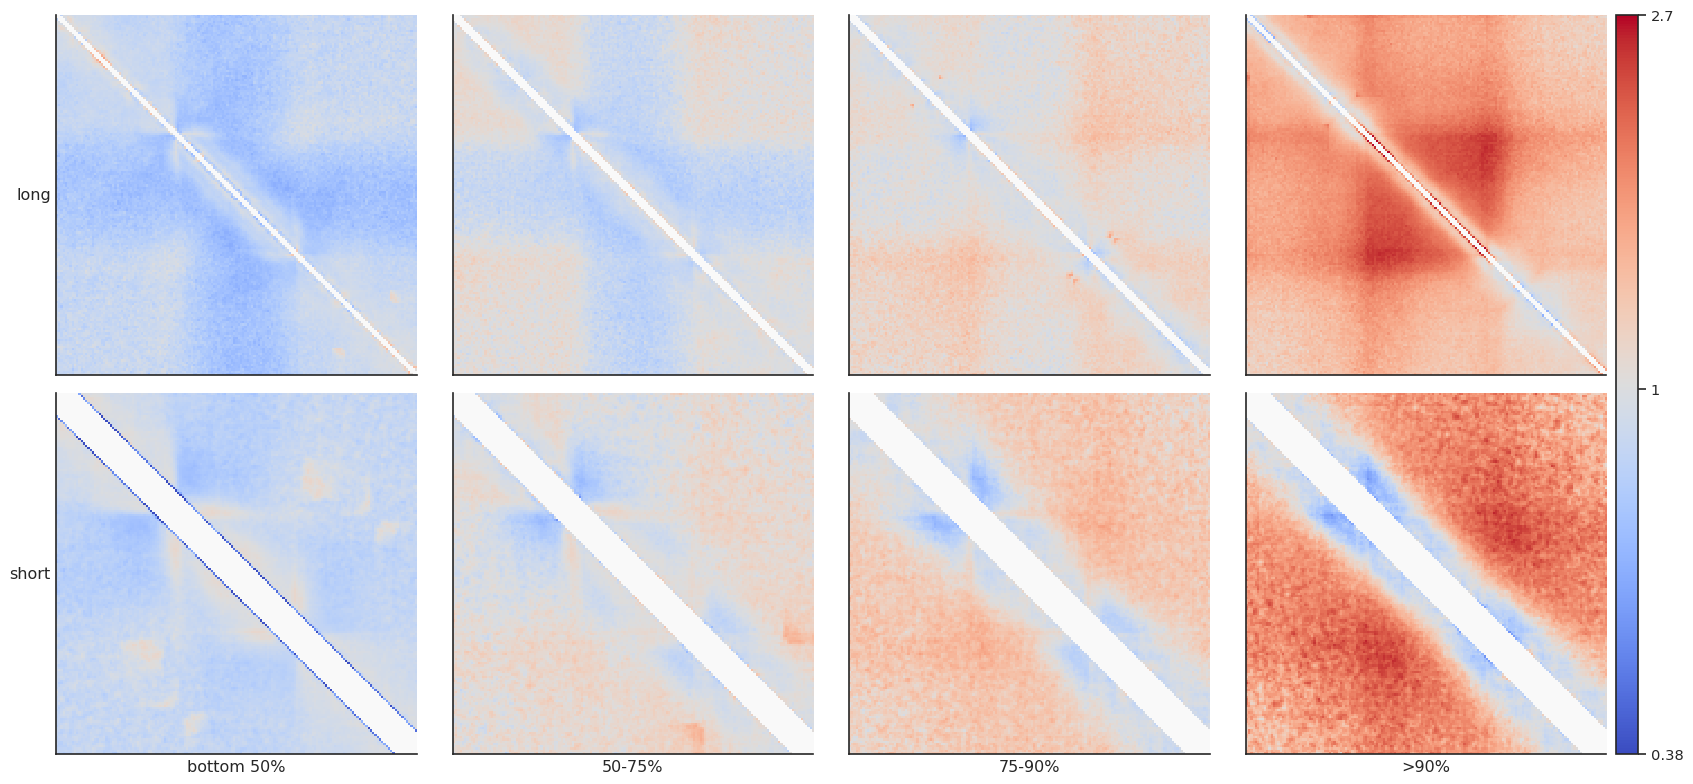

In [8]:
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='coolwarm', scale='log', sym=True,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.38, vmax=2.7,
             height=5)

plt.savefig('results/av_operon.flank2k.nascentCust.lengthBool.ooe.25bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [10]:
sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup,
#              rows='length_group1', row_order=['short', '25-50%', '50-75%', 'long'],
#              cols='nascent_group2', col_order=['0-33.3%', '33.3%-66.6%', '66.6-100%'],
#              score=False, cmap='coolwarm', scale='log', sym=True,
#              #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
#              vmin=0.56, vmax=1.8,
#              height=5)

# plt.savefig('results/av_operon.flank2k.ooe.50bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [24]:
operons_df.nascent_count.quantile([0.25, 0.5,0.75])

0.25    0.0
0.50    2.0
0.75    7.0
Name: nascent_count, dtype: float64

## Operon TSS

In [225]:
operonsTSS_df = operons_df.copy()
operonsTSS_df.loc[operonsTSS_df.strand == "+", 'end'] = operonsTSS_df.start + 1
operonsTSS_df.loc[operonsTSS_df.strand == "-", 'start'] = operonsTSS_df.end - 1
operonsTSS_df.head()

operon_id     operon_name    start      end strand  ngenes  \
0  RDBECOLIOPC02731          tnaCAB  3888435  3888436      +       3   
1  RDBECOLIOPC01121  malK-lamB-malM  4246784  4246785      +       3   
2  RDBECOLIOPC01401    garPLRK-rnpB  3274906  3274907      -       5   
3  RDBECOLIOPC03379     manXYZ-yobD  1902048  1902049      +       4   
4  RDBECOLIOPC00247           treBC  4466179  4466180      -       2   

                      genes  length  keep  counts        chrom  nascent_count  \
0            tnaC;tnaA;tnaB    3048  True    7024  NC_000913.3           2967   
1            malK;lamB;malM    3690  True    2991  NC_000913.3           2282   
2  garP;garL;garR;garK;rnpB    4691  True    2839  NC_000913.3           2534   
3       manX;manY;manZ;yobD    3211  True    2493  NC_000913.3           1049   
4                 treB;treC    3126  True    2345  NC_000913.3           1796   

   total_count  length_group lengthBool_group nascentCust_group nascent_group  
0       211205             3             long              >90%     66.6-100%  
1        86625             3             long              >90%     66.6-100%  
2       114023             3             long              >90%     66.6-100%  
3        82387             3             long              >90%     66.6-100%  
4        58797             3             long              >90%     66.6-100%

In [285]:
flank = 1000
pup_wt = coolpup.pileup(clr, operonsTSS_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     #rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     #rescale_flank=1,
                     # expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=2, nproc=32)
# pup_wt_ooe = coolpup.pileup(clr, operonsTSS_df, 
#                      groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      #rescale=True, rescale_size=int(1+flank * 2// resolution),  
#                      #rescale_flank=1,
#                      expected_df=expected,
#                      flip_negative_strand=True,
#                      flank=flank, min_diag=2, nproc=32)

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2224: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


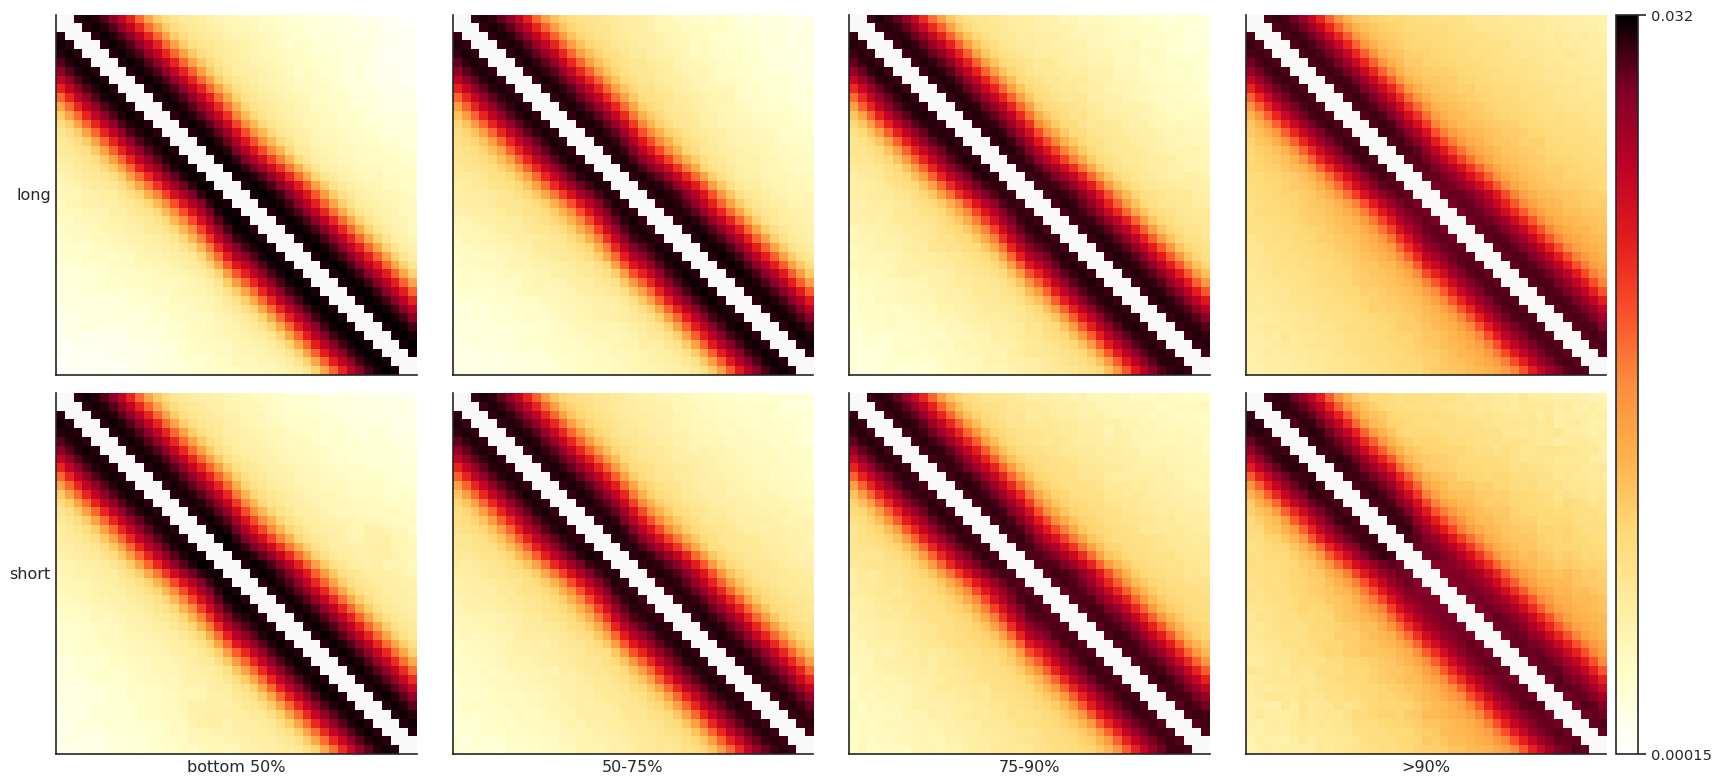

In [283]:
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_wt,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='fall', scale='log', sym=False,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             # vmin=0.00015, vmax=0.05,
             height=5)

# plt.savefig('results/av_operonTSS.flank1k.nascentCust.lengthBook.50bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [287]:
# %% load cooler
resolution = 25
clr_25 = cooler.Cooler('data/wt.combined.MG1655.mapq30.25.mcool::resolutions/' + str(resolution))
view_df_chromsizes = clr.chromsizes.reset_index()
view_df_chromsizes.columns = ['chrom', 'end']
view_df_chromsizes['start'] = 0
view_df_chromsizes['name'] = 'NC_000913.3'
view_df_chromsizes = view_df_chromsizes[['chrom', 'start', 'end', 'name']]
expected_25 = cooltools.expected_cis(clr_25, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


## Rif

In [7]:
flank = 2000
pup_rif25 = coolpup.pileup(clr_rif25, operons_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_rif25,
                     flip_negative_strand=True,
                     flank=flank, min_diag=8, nproc=32)

sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_rif25,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='fall', scale='log', sym=False,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.000015, vmax=0.001,
             height=5)

plt.savefig('results/av_operon_rif25.flank2k.nascentCust.lengthBool.10bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

NameError: name 'operons_df' is not defined

In [ ]:
flank = 2000
pup_rif25_ooe = coolpup.pileup(clr_rif750, operons_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_rif25,
                     flip_negative_strand=True,
                     flank=flank, min_diag=8, nproc=32)

sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_rif25,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='coolwarm', scale='log', sym=False,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.000015, vmax=0.001,
             height=5)

plt.savefig('results/av_operon_rif25.flank2k.nascentCust.lengthBook.100bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

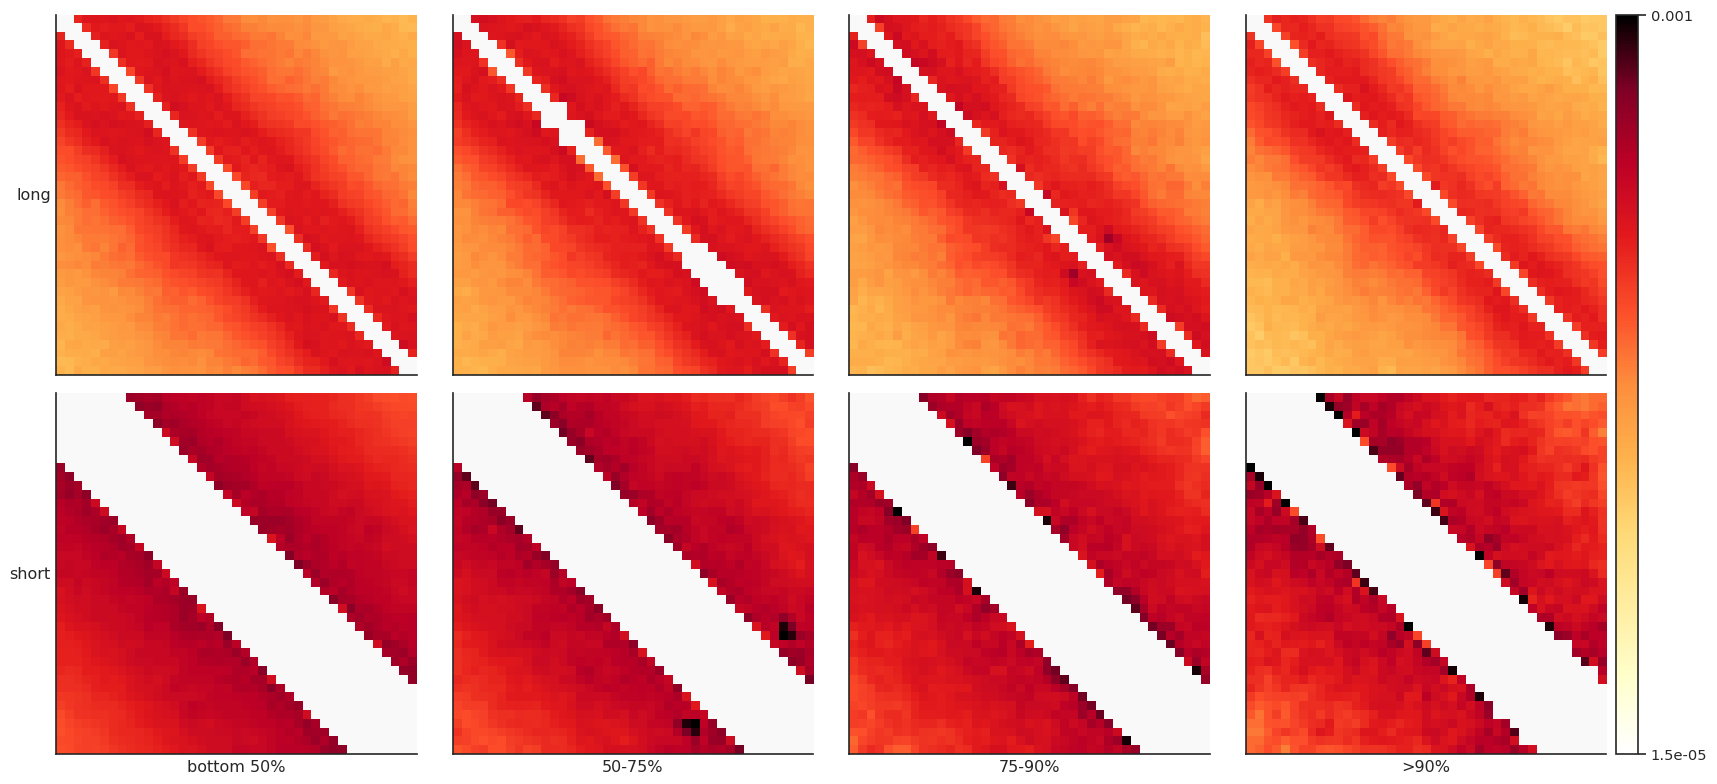

In [221]:
flank = 2000
pup_rif750 = coolpup.pileup(clr_rif750, operons_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     #expected_df=expected_rif25,
                     flip_negative_strand=True,
                     flank=flank, min_diag=8, nproc=32)

sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_rif750,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='fall', scale='log', sym=False,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.000015, vmax=0.001,
             height=5)

plt.savefig('results/av_operon_rif750.flank2k.nascentCust.lengthBook.100bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

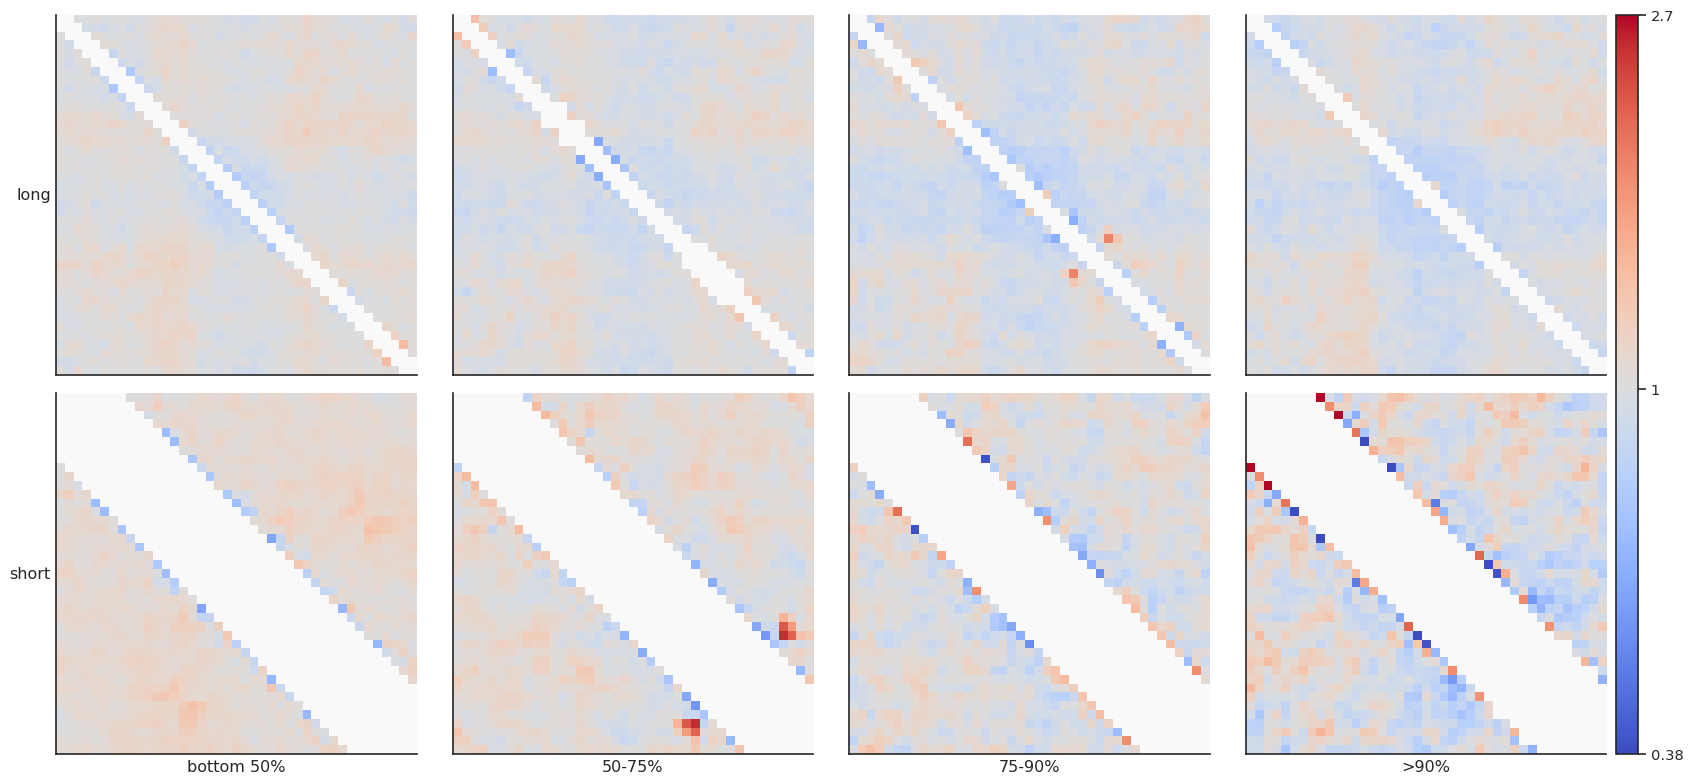

In [223]:
flank = 2000
pup_rif750_ooe = coolpup.pileup(clr_rif750, operons_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_rif750,
                     flip_negative_strand=True,
                     flank=flank, min_diag=8, nproc=32)
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_rif750_ooe,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='coolwarm', scale='log', sym=True,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.38, vmax=2.7,
             height=5)

plt.savefig('results/av_operon_rif750.flank2k.nascentCust.lengthBook.ooe.100bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [315]:
flank = 500
# pup_wt = coolpup.pileup(clr_25, operonsTSS_df, 
#                      groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      #rescale=True, rescale_size=int(1+flank * 2// resolution),  
#                      #rescale_flank=1,
#                      # expected_df=expected,
#                      flip_negative_strand=True,
#                      flank=flank, min_diag=2, nproc=32)
pup_wt25_ooe = coolpup.pileup(clr_25, operonsTSS_df, 
                     groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     #rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     #rescale_flank=1,
                     expected_df=expected_25,
                     flip_negative_strand=True,
                     flank=flank, min_diag=2, nproc=32)

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

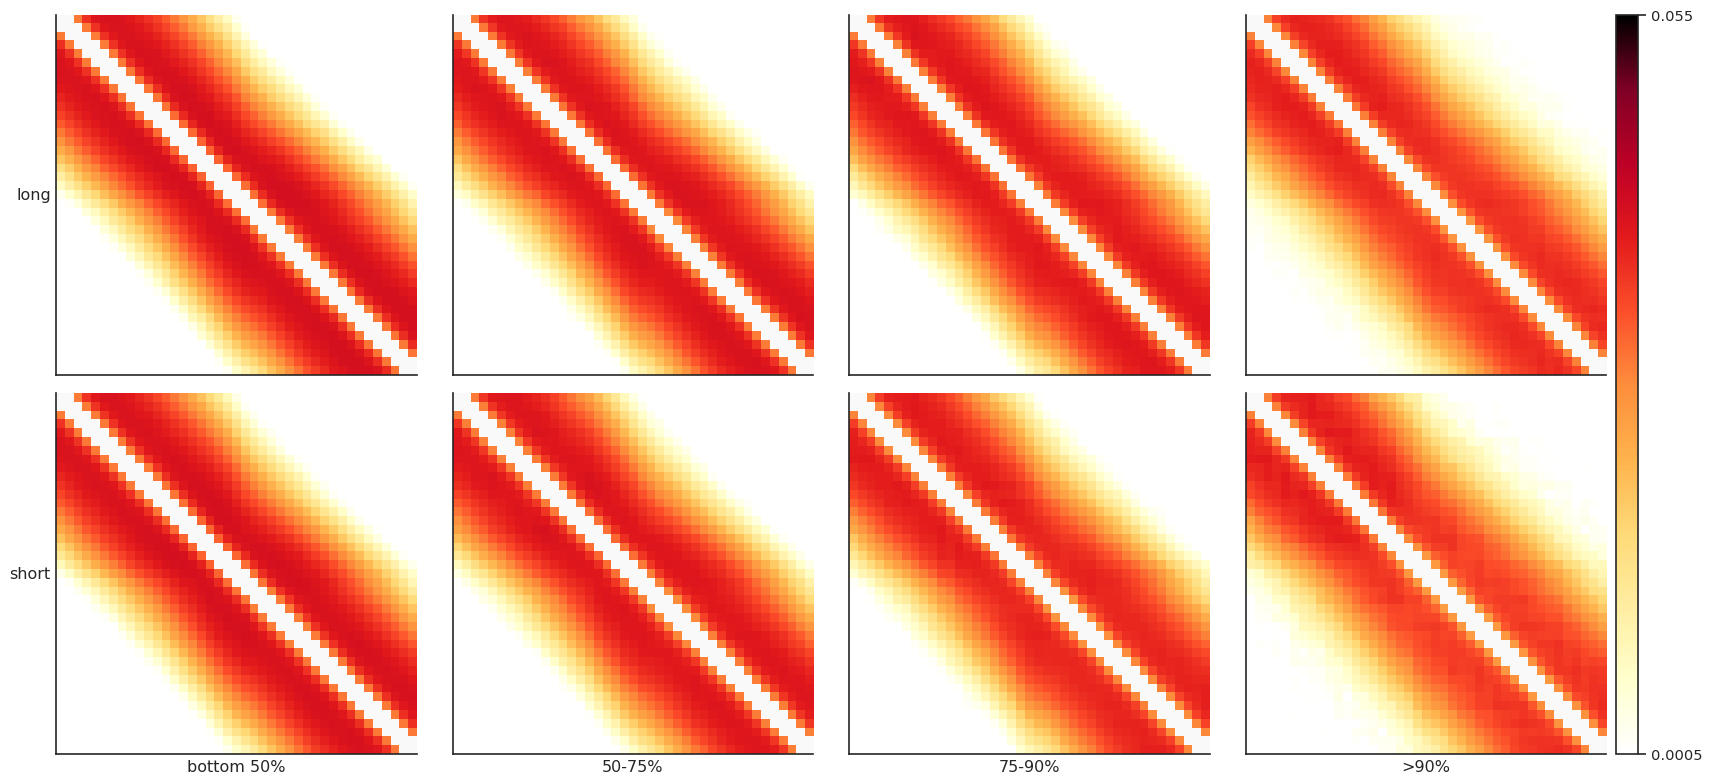

In [314]:
#500
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_wt,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='fall', scale='log', sym=False,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.0005, vmax=0.055,
             height=5)

plt.savefig('results/av_operonTSS.flank500.nascentCust.lengthBool.25bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

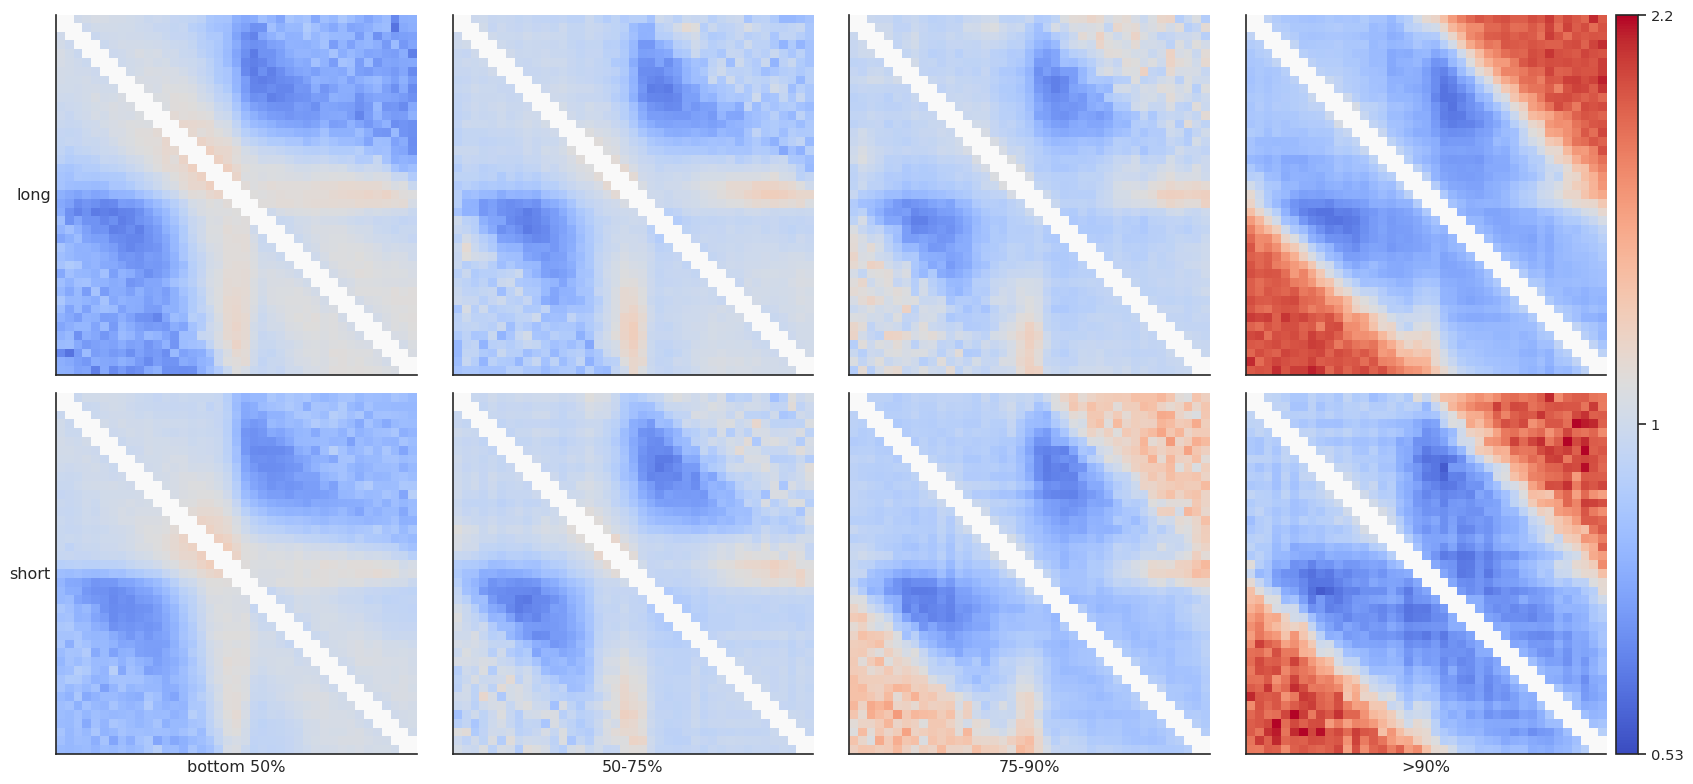

In [317]:
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_wt25_ooe,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='coolwarm', scale='log', sym=True,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.53, vmax=2.2,
             height=5)

plt.savefig('results/av_operonTSS.flank500.nascentCust.lengthBool.ooe.25bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

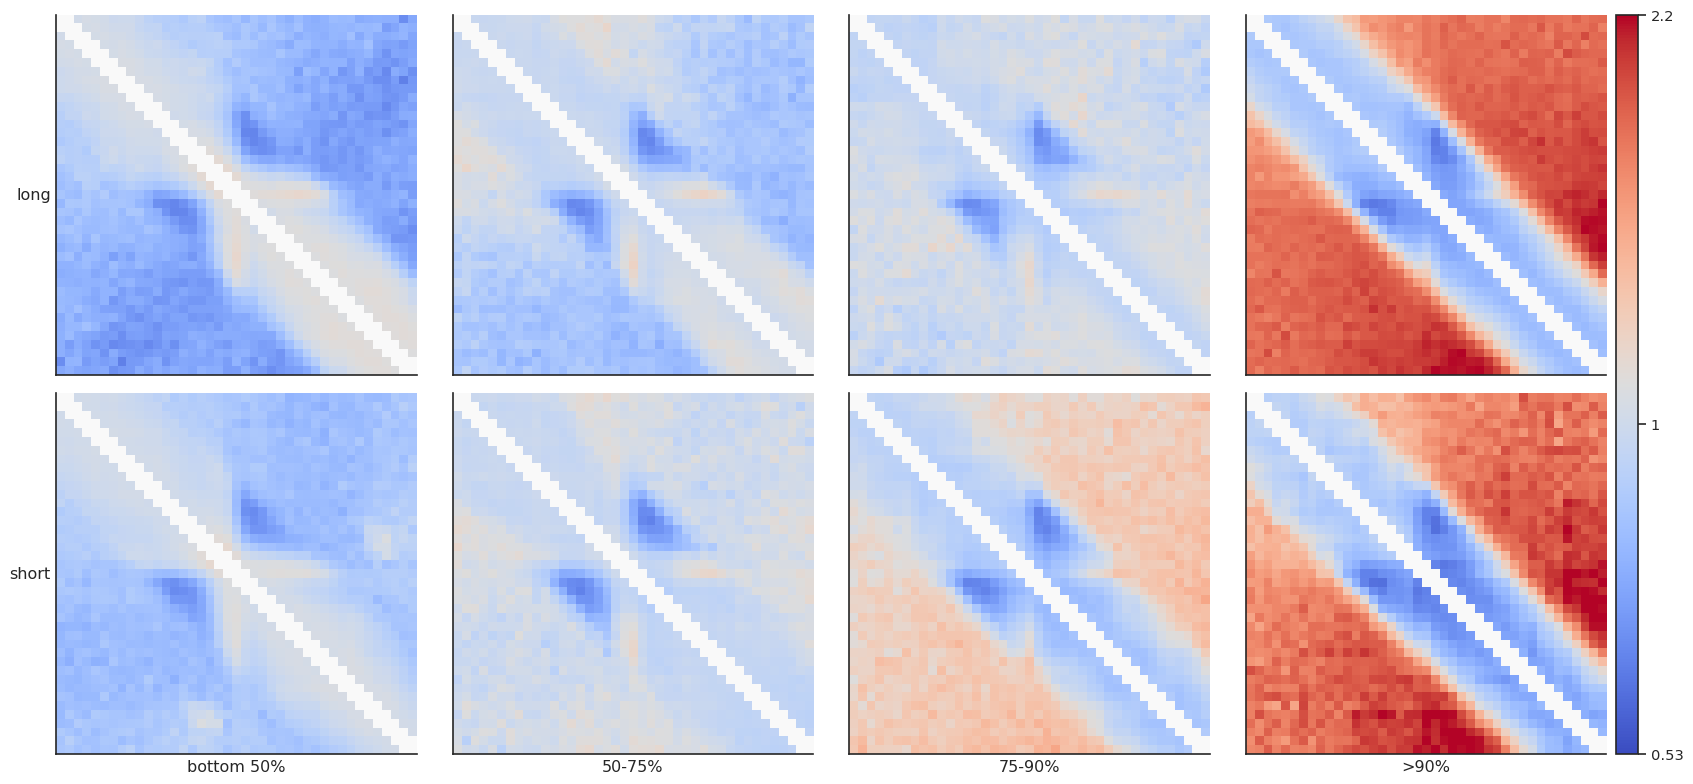

In [284]:
sns.set_theme(font_scale=2, style="ticks")
plotpup.plot(pup_wt_ooe,
             rows='lengthBool_group1', row_order=['long', 'short'],
             cols='nascentCust_group2', 
             col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
             score=False, cmap='coolwarm', scale='log', sym=True,
             #vmin=0.000005, vmax=0.0005, suitable fo rescale_flank=5, flank=10k
             vmin=0.53, vmax=2.2,
             height=5)

plt.savefig('results/av_operonTSS.flank1k.nascentCust.lengthBool.ooe.50bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

# Hairpins

In [7]:
hairpins_df_bed = bf.read_table('data/hairpins_25.bed', schema='bed')
hairpins_df_bed.head()

chrom   start     end  name  score  strand
0  NC_000913.3   58250   59425   NaN    NaN     NaN
1  NC_000913.3   83450   85875   NaN    NaN     NaN
2  NC_000913.3  150050  152625   NaN    NaN     NaN
3  NC_000913.3  150050  153550   NaN    NaN     NaN
4  NC_000913.3  150050  154625   NaN    NaN     NaN

In [255]:
flank = 2_000
# pup = coolpup.pileup(clr, hairpins_df_bed, 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_size=int(1+flank * 2// resolution),  
#                      rescale_flank=1,
#                      expected_df=expected,
#                      flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)

# plotpup.plot(pup,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='coolwarm', scale='log',
#              sym=True, #vmax=2,
#              height=5)
# plt.savefig('results/av_hairpin.flank_res1.ooe.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

In [253]:
# pup_Hp_notOoe = coolpup.pileup(clr, hairpins_df_bed, 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_size=int(1+flank * 2// resolution),  
#                      rescale_flank=1,
#                      # expected_df=expected,
#                      flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)

# plotpup.plot(pup_Hp_notOoe,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='fall', scale='log',
#              sym=False, vmin=0.000002, vmax=0.001,
#              height=5)
# plt.savefig('results/av_hairpin.flank_res1.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

In [252]:
# rif25
# flank = 2_000
# pup_rif25 = coolpup.pileup(clr_rif25, hairpins_df_bed , 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_flank=1, 
#                      rescale_size=int(1+flank * 2// resolution),  
#                      #rescale_flank=10,
#                      expected_df=expected_rif25,
#                      flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)
# plotpup.plot(pup_rif25,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='coolwarm', scale='log',
#              sym=True, vmax=3.5,
#              height=5)
# plt.savefig('results/av_hairpin_rif25.flank_res1.ooe.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

In [251]:
# rif750
# pup_Hp_rif750 = coolpup.pileup(clr_rif750, hairpins_df_bed , 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_flank=1, 
#                      rescale_size=int(1+flank * 2// resolution),  
#                      #rescale_flank=10,
#                      expected_df=expected_rif750,
#                      flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)
# plotpup.plot(pup_Hp_rif750,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='coolwarm', scale='log',
#              sym=True, vmax=2.2,
#              height=5)
# plt.savefig('results/av_hairpin_rif750.flank_res1.ooe.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

In [249]:
# rif25
# pup_rif25_notOoe = coolpup.pileup(clr_rif25, hairpins_df_bed , 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_flank=1, 
#                      rescale_size=int(1+flank * 2// resolution),  
#                      #rescale_flank=10,
#                      # expected_df=expected_rif25,
#                      flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)
# plotpup.plot(pup_rif25_notOoe,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='fall', scale='log',
#              vmin=0.000002, vmax=0.001,
#              height=5)
# plt.savefig('results/av_hairpin_rif25.flank_res1.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

In [250]:
# rif750
# pup_Hp_rif750_notOoe = coolpup.pileup(clr_rif750, hairpins_df_bed , 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_flank=1, 
#                      rescale_size=int(1+flank * 2// resolution),  
#                      #rescale_flank=10,
#                      # expected_df=expected_rif750,
#                      flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)
# plotpup.plot(pup_Hp_rif750_notOoe,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='fall', scale='log',
#              #sym=True, vmax=2.2,
#              vmin=0.000002, vmax=0.001,
#              height=5)
# plt.savefig('results/av_hairpin_rif750.flank_res1.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

# hCDs

In [8]:
hTAD_df_bedpe = bf.read_table('data/hTADS_25.bedpe', schema='bedpe')
hTAD_df_bedpe['chrom'] = hTAD_df_bedpe['chrom1']
hTAD_df_bedpe['start'] = hTAD_df_bedpe.start1
hTAD_df_bedpe['end'] = hTAD_df_bedpe.end2
hTAD_df_bed = hTAD_df_bedpe.loc[:,['chrom', 'start', 'end']]

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

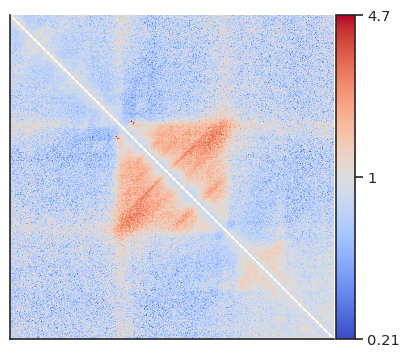

In [52]:
pup_hTAD_ooe = coolpup.pileup(clr, hTAD_df_bed, 
                     #groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected,
                     # flip_negative_strand=True,
                     #flank=flank, 
                     min_diag=2, nproc=32)
plotpup.plot(pup_hTAD_ooe,
             #cols='orientation', col_order=['--', '++'],
             score=False, cmap='coolwarm', scale='log',
             sym=True, #vmax=2,
             height=5)
plt.savefig('results/av_hTAD.flank_res1.ooe.10bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

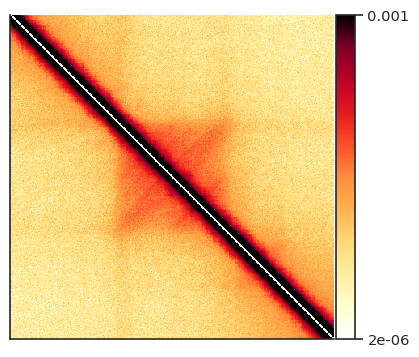

In [60]:
# pup_hTAD_Notooe = coolpup.pileup(clr, hTAD_df_bed, 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_size=int(1+flank * 2// resolution),  
#                      rescale_flank=1,
#                      # expected_df=expected,
#                      # flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)
plotpup.plot(pup_hTAD_Notooe,
             #cols='orientation', col_order=['--', '++'],
             score=False, cmap='fall', scale='log',
             sym=False, 
             vmin=0.000002, vmax=0.001,
             height=5)
plt.savefig('results/av_hTAD.flank_res1.10bp.pdf', dpi=100, bbox_inches='tight')
plt.show()

# TADs

In [9]:
TAD_df_bedpe = bf.read_table('data/TADS_25.bedpe', schema='bedpe')
TAD_df_bedpe['chrom'] = TAD_df_bedpe['chrom1']
TAD_df_bedpe['start'] = TAD_df_bedpe.start1
TAD_df_bedpe['end'] = TAD_df_bedpe.end2
TAD_df_bed = TAD_df_bedpe.loc[:,['chrom', 'start', 'end']]

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

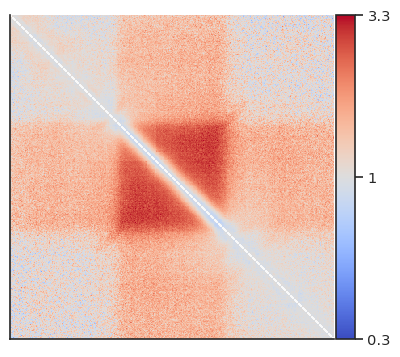

<Figure size 614.4x460.8 with 0 Axes>

In [62]:
pup_TAD_ooe = coolpup.pileup(clr, TAD_df_bed, 
                     #groupby=['lengthBool_group1', 'nascentCust_group2'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected,
                     # flip_negative_strand=True,
                     #flank=flank, 
                     min_diag=2, nproc=32)
plotpup.plot(pup_TAD_ooe,
             #cols='orientation', col_order=['--', '++'],
             score=False, cmap='coolwarm', scale='log',
             sym=True, #vmax=2,
             height=5)
plt.savefig('results/av_TAD.flank_res1.ooe.10bp.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

In [9]:
# pup_TAD_Notooe = coolpup.pileup(clr, TAD_df_bed, 
#                      #groupby=['lengthBool_group1', 'nascentCust_group2'],
#                      features_format='bed', 
#                      view_df=view_df_chromsizes, local=True,
#                      rescale=True, rescale_size=int(1+flank * 2// resolution),  
#                      rescale_flank=1,
#                      # expected_df=expected,
#                      # flip_negative_strand=True,
#                      #flank=flank, 
#                      min_diag=2, nproc=32)
# plotpup.plot(pup_TAD_Notooe,
#              #cols='orientation', col_order=['--', '++'],
#              score=False, cmap='fall', scale='log',
#              sym=False, #vmax=2,
#              vmin=0.000002, vmax=0.001,
#              height=5)
# plt.savefig('results/av_TAD.flank_res1.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()
# plt.clf()

# Features

In [10]:
TAD_df_bed['feature'] = 'CD'
hTAD_df_bed['feature'] = 'hCD'
hairpins_df_bed['feature'] = 'Hp'
features_df_bed = pd.concat([TAD_df_bed, hTAD_df_bed, hairpins_df_bed])
features_df_bed.head()

chrom   start     end feature  name  score  strand
0  NC_000913.3   49650   59950      CD   NaN    NaN     NaN
1  NC_000913.3   87800   93275      CD   NaN    NaN     NaN
2  NC_000913.3  106125  109000      CD   NaN    NaN     NaN
3  NC_000913.3  121900  129475      CD   NaN    NaN     NaN
4  NC_000913.3  182450  184375      CD   NaN    NaN     NaN

In [35]:
clr.info #485,778,098 662_252_537
# clr_rif25.info #100,784,455 131_983_325
# clr_rif750.info #101,230,501 125_993_168
# cooltools.sample(clr, 'data/wt.sample.cool', count=125_000_000, exact=False, nproc=32)
# cooltools.sample(clr_rif25, 'data/rif25.sample.cool', count=125_000_000, exact=False, nproc=32)

INFO:root:creating a Pool of 32 workers
INFO:root:creating a Pool of 32 workers


In [14]:
resolution = 10
clr_sample = cooler.Cooler('data/wt.sample.cool')
clr_rif25_sample = cooler.Cooler('data/rif25.sample.cool')
clr_rif25_sample.info['sum']

124998810

In [15]:
expected_sample = cooltools.expected_cis(clr_sample, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

expected_rif25_sample = cooltools.expected_cis(clr_rif25_sample, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


## Observed

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2224: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


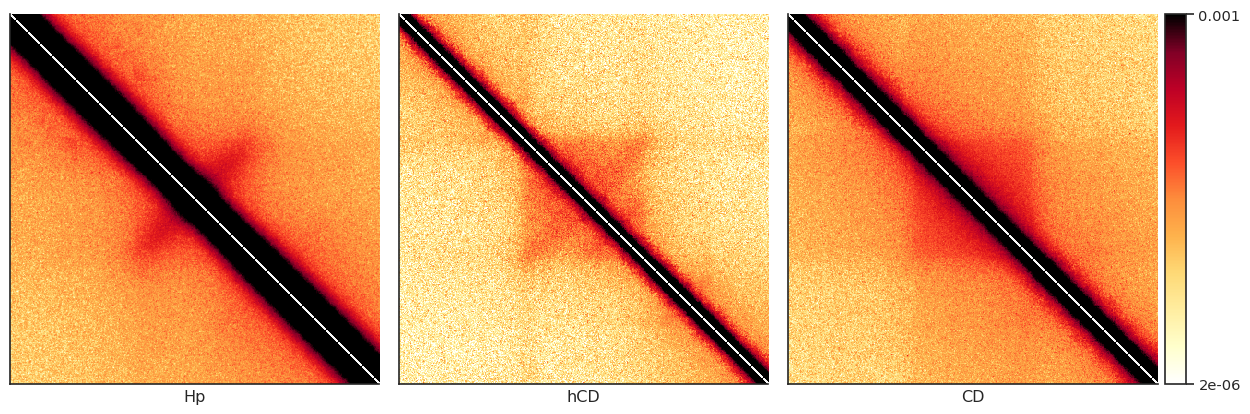

<Figure size 614.4x460.8 with 0 Axes>

In [43]:
flank = 2000
pup_feature = coolpup.pileup(clr_sample, features_df_bed, 
                     groupby=['feature1',],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     min_diag=2, nproc=32)

In [42]:
pup_feature_rif25 = coolpup.pileup(clr_rif25_sample, features_df_bed, 
                     groupby=['feature1',],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     min_diag=2, nproc=32)

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2224: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


In [13]:
pup_feature_rif750 = coolpup.pileup(clr_rif750, features_df_bed, 
                     groupby=['feature1',],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     min_diag=2, nproc=32)

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:919: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 401x401 pixels
INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 343
INFO:coolpuppy:Total number of piled up windows: 343
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2224: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


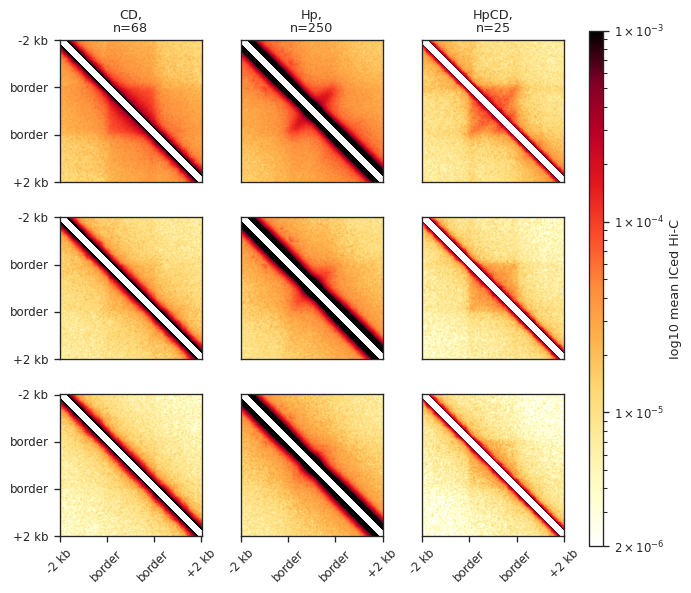

<Figure size 614.4x460.8 with 0 Axes>

In [271]:
import matplotlib.cm
from matplotlib import ticker
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    ABCJ
    DEFJ
    HGIJ
    """, figsize=(18*cm, 5*3.1*cm), 
    constrained_layout = True,
    gridspec_kw={'width_ratios':[1, 1, 1, 0.1]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'border', 'border', '+2 kb']


letter_dic = {'A':0,'B':1,'C':2,'D':0,'E':1,'F':2,'H':0,'G':1,'I':2}
for letter in letter_dic.keys():
    i = letter_dic[letter]
    if letter in ['A','B','C']:
        current_pup = pup_feature
    if letter in ['D','E','F']:
        current_pup = pup_feature_rif25
    if letter in ['H','G','I']:
        current_pup = pup_feature_rif750
    norm = mpl.colors.LogNorm(vmin=0.000002, vmax=0.001)
    # if i == 0:
    #     norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.001) 
    # elif i == 1:
    #     norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.0005) 
    # else: 
    #     norm = mpl.colors.LogNorm(vmin=0.000002, vmax=0.001)
    
    im = axs[letter].imshow(
        current_pup.loc[i, 'data'],
        norm=norm,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "A":
        axs[letter].set(xticks=[], yticks=ticks_pixels_borders, 
                        yticklabels=ticks_borders,
                        title="%s,\nn=%s" %(current_pup.feature1[i], current_pup.n[i]),
                         # ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter == 'B':
        axs[letter].set(xticks=[], yticks=[], 
                        title="%s,\nn=%s" %(current_pup.feature1[i], current_pup.n[i]))
    
    if letter == 'C':
        axs[letter].set(xticks=[], yticks=[], 
                        title="%s,\nn=%s" %("HpCD", current_pup.n[i]),
                       )
    if letter in ['D']:
        axs[letter].set(xticks=[], #title="%s,\nn=%s" %(pup_feature.feature1[i], pup_feature.n[i]),
                        #xticklabels=ticks_kbp,
                        yticks=ticks_pixels_borders, yticklabels=ticks_borders)
        
    if letter in ['E','F']:
        axs[letter].set(xticks=[], #title="%s,\nn=%s" %(pup_feature.feature1[i], pup_feature.n[i]),
                        #xticklabels=ticks_kbp,
                        yticks=[])
    if letter == "H":
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, 
                        yticks=ticks_pixels_borders, yticklabels=ticks_borders, 
                        #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                        #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter in ['G','I']:
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders,
                         yticks=[], #xlabel="\n".join(wrap('relative position, kbp', 25))
                       )
cax = axs['J']
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'fall'), ticks=[0.000002, 0.00001, 0.0001, 0.001],
             format=ticker.FuncFormatter(fmt),
             cax=cax, label = 'log10 mean ICed Hi-C')
# cax.set_yticklabels([2e-06, 1e-05, 1e-04, 5e-04])
cax.set_yticklabels([], minor=True)
# cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

plt.savefig('results/av_feature_hic.mean.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

## OOE

In [16]:
flank = 2000
pup_feature_ooe = coolpup.pileup(clr_sample, features_df_bed, 
                     groupby=['feature1',],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_sample,
                     # flip_negative_strand=True,
                     #flank=flank, 
                     min_diag=2, nproc=32)


{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [ ]:
pup_feature_rif25_ooe = coolpup.pileup(clr_rif25_sample, features_df_bed, 
                     groupby=['feature1',],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_rif25_sample,
                     # flip_negative_strand=True,
                     #flank=flank, 
                     min_diag=2, nproc=32)

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [ ]:
pup_feature_rif750 = coolpup.pileup(clr_rif750, features_df_bed, 
                     groupby=['feature1',],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_rif750,
                     # flip_negative_strand=True,
                     #flank=flank, 
                     min_diag=2, nproc=32)

In [ ]:
import matplotlib.cm
from matplotlib import ticker
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    ABCJ
    DEFJ
    HGIJ
    """, figsize=(18*cm, 5*3.1*cm), 
    constrained_layout = True,
    gridspec_kw={'width_ratios':[1, 1, 1, 0.1]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'border', 'border', '+2 kb']


letter_dic = {'A':0,'B':1,'C':2,'D':0,'E':1,'F':2,'H':0,'G':1,'I':2}
for letter in letter_dic.keys():
    i = letter_dic[letter]
    if letter in ['A','B','C']:
        current_pup = pup_feature
    if letter in ['D','E','F']:
        current_pup = pup_feature_rif25
    if letter in ['H','G','I']:
        current_pup = pup_feature_rif750
    norm = mpl.colors.LogNorm(vmin=0.6, vmax=2.7)
    # if i == 0:
    #     norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.001) 
    # elif i == 1:
    #     norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.0005) 
    # else: 
    #     norm = mpl.colors.LogNorm(vmin=0.000002, vmax=0.001)
    
    im = axs[letter].imshow(
        current_pup.loc[i, 'data'],
        norm=norm,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "A":
        axs[letter].set(xticks=[], yticks=ticks_pixels_borders, 
                        yticklabels=ticks_borders,
                        title="%s,\nn=%s" %(current_pup.feature1[i], current_pup.n[i]),
                         # ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter == 'B':
        axs[letter].set(xticks=[], yticks=[], 
                        title="%s,\nn=%s" %(current_pup.feature1[i], current_pup.n[i]))
    
    if letter == 'C':
        axs[letter].set(xticks=[], yticks=[], 
                        title="%s,\nn=%s" %("HpCD", current_pup.n[i]),
                       )
    if letter in ['D']:
        axs[letter].set(xticks=[], #title="%s,\nn=%s" %(pup_feature.feature1[i], pup_feature.n[i]),
                        #xticklabels=ticks_kbp,
                        yticks=ticks_pixels_borders, yticklabels=ticks_borders)
        
    if letter in ['E','F']:
        axs[letter].set(xticks=[], #title="%s,\nn=%s" %(pup_feature.feature1[i], pup_feature.n[i]),
                        #xticklabels=ticks_kbp,
                        yticks=[])
    if letter == "H":
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, 
                        yticks=ticks_pixels_borders, yticklabels=ticks_borders, 
                        #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                        #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    if letter in ['G','I']:
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders,
                         yticks=[], #xlabel="\n".join(wrap('relative position, kbp', 25))
                       )
cax = axs['J']
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'fall'), ticks=[0.6, 1.0, 2.7],
             # format=ticker.FuncFormatter(fmt),
             cax=cax, label = 'ooe ICed Hi-C')
cax.set_yticklabels([0.6, 1.0, 2.7], minor=True)
# cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

plt.savefig('results/av_feature_hic.ooe.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()